## REI602M Machine Learning - Homework 10
### Due: *Thursday* 28.3.2019

**Objectives**: Convolutional neural networks (CNNs), Recurrent neural networks (RNNs)

**Name**: Emil Gauti Friðriksson, **email: ** egf3@hi.is, **collaborators:** (if any)

**Notes**: You need TensorFlow for this assignment. Refer to installation instructions on Piazza.

1\. [Image classification with CNNs, 50 points] The CIFAR-10 is a small image classification dataset consisting of 60000 color images of size 32x32 in 10 classes.
<img src="./cifar-10-classes.png" width="500"/>
Human accuracy on CIFAR-10 is approximately 94% while state of the art CNNs achieve around 99% accuracy! You can expect accuracy close to 80% in this problem and around 84% in problem 2 (this is comparable to state of the art performance in 2013). 

The data is split into training and validation sets below. There is no separate test set so the accuracy estimates that you obtain will be somewhat optimistic. Starting from a simple network architecture you gradually add layers, with the aim of improving accuracy. In each of the tasks below, you report the final training and validation accuracies and provide a graph showing how they change during training. What can you conclude from the graph in each case? Monitor the accuracy during training and stop when the validation accuracy no longer improves. Ten epochs should be sufficient in most cases.

In the following, INPUT denotes the input layer, FC denotes a fully connected layer, CONV-$m$ represents a 2D-convolutional layer with $m$ filters, POOL corresponds to a 2D pooling layer, RELU to ReLU activation units, [...]\*n denotes repetition $n$ times of the units inside the brackets. The last last layer (FCS) denotes a fully connected layer with 10 nodes and softmax activation (this is the classification step). Use dropout for regulatization and only following FC layers.

a) INPUT -> [FC -> RELU] -> FCS (conventional feedforward network)

b) INPUT -> [CONV-32 -> RELU -> POOL] -> FCS (minimalistic CNN)

c) INPUT -> [CONV-32 -> RELU]\*2 -> POOL]\*2 -> [FC -> RELU]\*1 -> FCS

d) [CONV-32 -> RELU]\*2 -> POOL -> [CONV-64 -> RELU]\*2 -> POOL -> [CONV-128 -> RELU]\*3 -> POOL -> FC -> FCS (simplified VGGnet)

*Comments*:
* Implement your networks using Keras. You can see examples of fully connected networks in `v10_nn_keras.ipynb` and a convolutional network in `v11_dnn.ipynb`.
* Regularization of convolutional layers does not seem to be very effective. Fully connected need regularization to prevent overfitting. Dropout with $p=0.5$ is usually quite effective.
* Use `padding="same"` to zero-pad the input to convolutional layers.
* You can continue training a model by calling `model.fit` repeatedly.
* To save a model use `model.save(filename)`. You may also want to look into model checkpoints and early stopping. See `ModelCheckpoint` and `EarlyStopping` in the Keras documentation.
* The CIFAR-10 "high score" was obtained by training giant deep networks on huge image databases in order to learn feature maps relevant to image classification. The networks were then fine-tuned on CIFAR-10 (this an example of *transfer learning*).

In [4]:
# Load the CIFAR-10 data set of tiny images (~170 MB)
import numpy as np
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data() # Takes considerable time first time around

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=len(np.unique(y_train))
print("Number of classes:", num_classes)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Convert to 32-bit floats
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Scale data
x_train /= 255
x_test /= 255

# THINK:
x_val = x_test
y_val = y_test

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Number of classes: 10


I let all the tests run for 10 epochs as the time it takes isn't that much

In [19]:
#a) INPUT -> [FC -> RELU] -> FCS (conventional feedforward network)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense#, Activation
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import Adadelta
num_epochs = 10
batch_sizeA=300
input_shape = x_train.shape[1:]
modelA = Sequential()
modelA.add(Flatten(input_shape=input_shape))
modelA.add(Dense(300, activation='relu'))
modelA.add(Dropout(0.5))
modelA.add(Dense(num_classes, activation='softmax'))

modelA.summary()

modelA.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

historyA=modelA.fit(x_train, y_train,
                  batch_size=batch_sizeA,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=(x_val, y_val))
scoreA = modelA.evaluate(x_val, y_val, verbose=0)
print('val loss:', scoreA[0])
print('val accuracy:', scoreA[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 300)               921900    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                3010      
Total params: 924,910
Trainable params: 924,910
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 64us/step - loss: 2.2026 - acc: 0.1921 - val_loss: 1.9722 - val_acc: 0.3228
Epoch 2/10
50000/50000 [==============================] - 2s 46us/step - loss: 2.

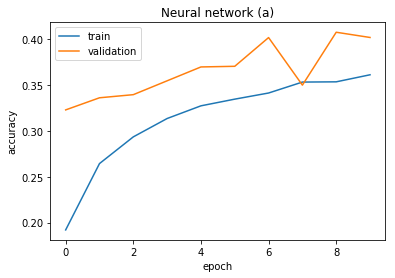

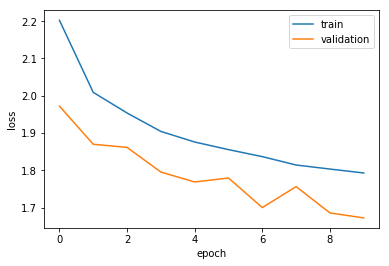

In [25]:
#Plottum gögnin okkar
#(a)
import matplotlib.pyplot as plt
plt.plot(historyA.history['acc'])
plt.plot(historyA.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Neural network (a)')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(historyA.history['loss'])
plt.plot(historyA.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

We are not getting great accuracy over here but this is only the start, we expect the accuracy as well as the loss function to return better values as the models get more complicated

In [5]:
#(b)INPUT -> [CONV-32 -> RELU -> POOL] -> FCS (minimalistic CNN)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense#, Activation
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import Adadelta
batch_sizeB=300
num_epochs=10
input_shape = x_train.shape[1:]
modelB = Sequential()

modelB.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
modelB.add(MaxPooling2D(pool_size=(2, 2)))

modelB.add(Flatten())
modelB.add(Dense(10, activation='softmax'))


modelB.summary()

modelB.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

historyB=modelB.fit(x_train, y_train,
                  batch_size=batch_sizeB,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=(x_val, y_val))
scoreB = modelB.evaluate(x_val, y_val, verbose=0)
print('val loss:', scoreB[0])
print('val accuracy:', scoreB[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.8481 - acc: 0.3537 - val_loss: 1.5437 - val_acc: 0.4665
Epoch 2/10
50000/50000 [==============================] - 3s 54us/step - loss: 1.47

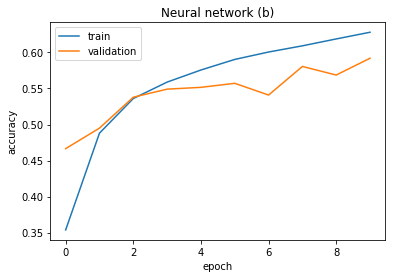

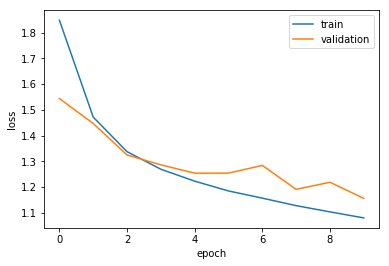

In [7]:
#Plottum gögnin okkar
#(b)
import matplotlib.pyplot as plt
plt.plot(historyB.history['acc'])
plt.plot(historyB.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Neural network (b)')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

These results are a lot more promising than what we got from (a). In both the graphs we see how train and validation stay more tightly together than in (a). We also get more accuracy as well as a lower loss

In [16]:
#c) INPUT -> [[CONV-32 -> RELU]*2 -> POOL]*2 -> [FC -> RELU]*1 -> FCS
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense#, Activation
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import Adadelta
batch_sizeB=300
num_epochs=10
input_shape = x_train.shape[1:]
modelC = Sequential()

modelC.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
modelC.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))

modelC.add(MaxPooling2D(pool_size=(2, 2)))

modelC.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
modelC.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))

modelC.add(MaxPooling2D(pool_size=(2, 2)))

modelC.add(Flatten())
modelC.add(Dense(100, activation='relu'))
modelC.add(Dense(10, activation='softmax'))



modelC.summary()

modelC.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

historyC=modelC.fit(x_train, y_train,
                  batch_size=batch_sizeB,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=(x_val, y_val))
scoreC = modelC.evaluate(x_val, y_val, verbose=0)
print('val loss:', scoreC[0])
print('val accuracy:', scoreC[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
__________

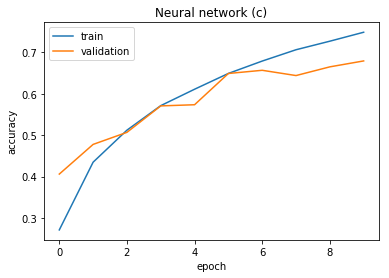

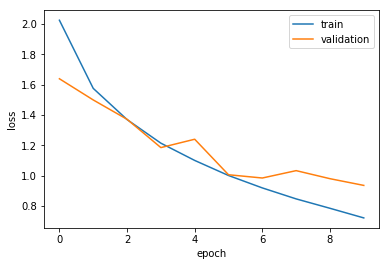

In [27]:
#Plottum gögnin okkar
#(c)
import matplotlib.pyplot as plt
plt.plot(historyC.history['acc'])
plt.plot(historyC.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Neural network (c)')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(historyC.history['loss'])
plt.plot(historyC.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

These results are similar to the one we got in (b) but the accuracy has risen and the loss has gone down even further. This is so far the best results.

In [17]:
#[CONV-32->RELU]*2 -->POOL->[CONV-64 -> RELU]*2->POOL->[CONV-128 -> RELU]*3 -> POOL -> FC -> FCS 
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense#, Activation
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import Adadelta
batch_sizeD=300
num_epochs=10
input_shape = x_train.shape[1:]
modelD = Sequential()

modelD.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
modelD.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))

modelD.add(MaxPooling2D(pool_size=(2, 2)))

modelD.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
modelD.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))

modelD.add(MaxPooling2D(pool_size=(2, 2)))

modelD.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
modelD.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
modelD.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))

modelD.add(MaxPooling2D(pool_size=(2, 2)))

modelD.add(Flatten())
modelD.add(Dense(100, activation='relu'))
modelD.add(Dense(10, activation='softmax'))



modelD.summary()

modelD.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

historyD=modelD.fit(x_train, y_train,
                  batch_size=batch_sizeD,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=(x_val, y_val))
scoreD = modelD.evaluate(x_val, y_val, verbose=0)
print('val loss:', scoreD[0])
print('val accuracy:', scoreD[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 128)         73856     
__________

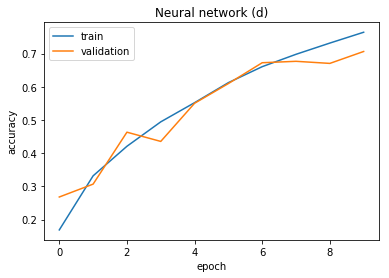

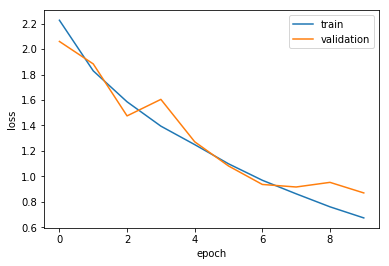

In [28]:
#Plottum gögnin okkar
#(d)
import matplotlib.pyplot as plt
plt.plot(historyD.history['acc'])
plt.plot(historyD.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Neural network (d)')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(historyD.history['loss'])
plt.plot(historyD.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

The accuracy and loss of the validation follow the trendline of the train very closely and intersect it often. This is a new behaviour. This is also the best results in regards to accuracy and loss.

2\. [Data augmentation, 20 points] When the amount of training data is small in relation to the number of parameters in a model, overfitting becomes an issue. In many specialized image recognition tasks such as tumor classification, the amount of labeled data is often quite limited and a state of the art convolutional network are likely to severly overfit the data set. Data augmentation refers to techniques that create additional training examples from the original data set. For image data it is possible to create additional training examples by simple operations such as reflection, cropping and translation as well as by changing the color palette.

Take the best network from problem 1) and perform image augmention *during* training using the `ImageDataGenerator` class in Keras. You may need to train for more than 10 epochs. Report your results in the same way as you did in problem 1). Comment briefly on the type of mistakes that your network makes.

We will be using model D as it gave the best results. We'll be increasing the number of epochs to 20.

In [11]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense#, Activation
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import Adadelta
batch_size2=300
num_epochs2=20
input_shape = x_train.shape[1:]

model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))

model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
model2.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))

model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
model2.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))
model2.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding = "same"))

model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(100, activation='relu'))
model2.add(Dense(10, activation='softmax'))



model2.summary()


model2.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, rotation_range=0,  
                             width_shift_range=0.1, height_shift_range=0.1, 
                             horizontal_flip = False, vertical_flip = True)

datagen.fit(x_train)

history2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size2),
                         steps_per_epoch=len(x_train) / batch_size2, 
                         epochs=num_epochs2,validation_data=(x_val, y_val))


score2 = model2.evaluate(x_val, y_val, verbose=0)
print('val loss:', score2[0])
print('val accuracy:', score2[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         73856     
__________

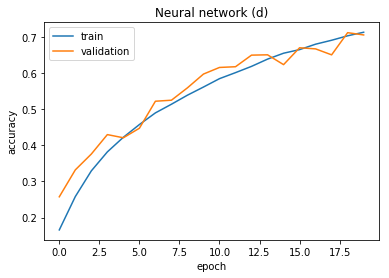

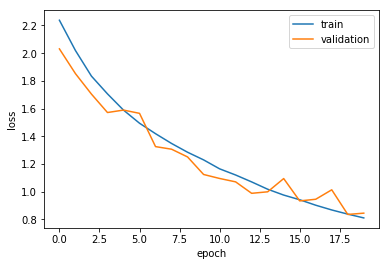

In [12]:
import matplotlib.pyplot as plt
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Neural network')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Considering we went through 20 epochs now we see that we get diminishing returns that indicates an upper limit on accuracy. We also see that after 10 epochs we get poorer results than in (d) in problem 1. This indicates that the way we generate data is not doing so well. We do manage to get very close to the results in problem 1 though.

The accuracy increases to the very end.

3\. [Learning to perform subtraction with an RNN, 30 points] Take a close look at the recurrent neural network code shown in class (https://keras.io/examples/addition_rnn/). It shows how sequence to sequence learning can be used to learn addition of small numbers. This is done by presenting the network with input-output pairs, where the input is a string on the form "123+456" and the output is "579".

Modify the code for addition so that the network learns *subtraction* of three digit numbers. What is the validation accuracy after 30 epochs? You should mark all the modifications that you do to the code by inserting comments on the form
```python
# START MOD
...
# END MOD
```

*Comments*:
* You need to modify the test that prevents the same example occurring multiple times in the list of "questions" (addition is commutative but subtraction is not).
* `val_acc` does not represent the fraction of correctly predicted validation examples (I have no idea why!) You need to write a short piece of code that sends all the examples in the validation set through the network and counts the number of mistakes.

I thought this problem was interesting and tried to improve the results by running 40 epochs.

In [13]:
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
import numpy as np


class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.

        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.

        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.

        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
#START MOD
chars = '0123456789- '
#END MOD
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    #START MOD
    key = tuple((a, b))
    #END MOD
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    #START MOD
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    #END MOD
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 40):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

#Evaluate performance on the validation set
    corr=0
    for ind in range(len(x_val)):
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        if correct == guess:
            corr+=1
    print("Validation accuracy:", corr/len(x_val))

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________

--------------------------------------------------
Iteration 1
Train on 45000 samples, validat

After 30 Iteration we have accuracy 0.9138 which is pretty good considering we started in 0.0032, but after the 30th epoch we steadily rise to 0.9806 in validation accuracy when we hit iteration number 39. It's likely that you can get as accurate as you want if you give yourself sufficient amount of iterations.